In [74]:
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm
import datetime
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
from flox.xarray import xarray_reduce
import dask
from dask.diagnostics import ProgressBar
# from braceexpand import braceexpand
import pandas as pd
from math import cos, asin, sqrt, pi
%matplotlib inline
%config InlineBackend.figure_format='retina'
# This code make the next section of code to stop acting silly
dask.config.set({"array.slicing.split_large_chunks": True})
	# True: smaller chunks are used
	# False: large chunks are accepted

#### Functions

In [61]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.lon.values/15).round(decimals=0)
	hour_offset = hour_offset.repeat(len(da.time)).reshape((len(da.lon),len(da.time))).T
	local_time = np.empty([len(da.time),len(da.lon)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('time','lon'),local_time))
	return da

In [69]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
	# dim_num = 2 or 3;  This indicates to the function if you want Local Time
		# within the dataarray to be only a function of time and longitude, or
		# time, lognitude, and latitude. This is a preference and if you don't need
		# it as a function of latitude, it will save lots of time going with dim_num = 2.
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.


def assign_LT_coord(da, dim_num):
	hour_offset = (da.lon.values/15).round(decimals=0)

	# Local Time is a function of only Time and Longitude
	if dim_num==2:
		local_time = np.empty([len(da.time),len(da.lon)], dtype=object)
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[1]):
				local_time[i,j] = da.time.values[i] + np.timedelta64(int(hour_offset[j]),'h')
		da = da.assign_coords(LocalTime=(('time','lon'),local_time))
	
	# Local Time is a function of Time, Longitude, and Latitude
	else:
		local_time = np.empty([len(da.time),len(da.lat),len(da.lon)], dtype='datetime64[ns]')
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[2]):
				local_time[i,:,j] = da.time.values[i] + np.timedelta64(int(hour_offset[j]),'h')
		da = da.assign_coords(LocalTime=(('time','lat','lon'),local_time))
	return da


In [3]:
def hov_diurnal(da):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.lat>lat_avg_bound[0])&(da.lat<lat_avg_bound[1]),drop=True).mean(dim='lat')
    # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
        # diurnal cycle of rain rate.
    array = np.zeros((da_avg.shape[1],24))
    # Loop through each longitude, look through all the timesteps and group them by hour,
        # and then average the values at each hour. Output the 1x24 array into the empty array
    for i in range(array.shape[0]):
        array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    return array

In [4]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components
# Example:
	# da_x = da_d01_U
	# da_y = da_d01_V
	# theta = pi/4	# 45° rotation anti-clockwise
	# da_d01_U_rotated, da_d01_V_rotated = rotate_vec(da_x, da_y, theta)

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if theta > 0:
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if theta < 0:
		da_x_rot = da_x*cos(-theta) + da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [5]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 	matrix in time, height, distance, and # of lines
	# 					or time, distance, and # of lines if using a 2-D variable
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to lat and lon.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.lat) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.lat) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.lon) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.lon) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.lat[start_ilat], da.lat[end_ilat], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.lon[start_ilon], da.lon[end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.lat[start_ilat], da.lat[end_ilat], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.lon[start_ilon], da.lon[end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(lat=line_coords[0,:]+spread[i], lon=line_coords[1,:]-spread[i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					lat = da_interp.lat[j],
					lon = da_interp.lon[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					lat = da_interp.lat[j],
					lon = da_interp.lon[j])
				da_cross[:,j,i] = data

		all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		all_line_coords[1,:,i] = line_coords[1,:]-spread[i]

	return da_cross, all_line_coords

In [6]:
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [7]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [8]:
def da_info(da):
    print('Description: ', da.description, '\nUnits: ',da.units, '\nDimensions: ', da.dims, '\nShape: ', da.shape)

#### Global Variables

In [166]:
# Set the bounds you want to look at
# lat_bound = [-10,10]		# South to North
lat_bound = [-12.5,12.5]	# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-10,10]

In [181]:
# Run this block of code once to save sliced dataset

# Uncomment below to slice the monthly data into an easier to handle matrix
file_IMERG = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/imerg.v7b.201512.nc4'
lats = [-12.5, 12.5]
lons = [90, 125]
times = ['2015-12-20 00:00','2015-12-30 00:00']
ds_RR_IMERG = xr.open_dataset(file_IMERG)
file_sliced_IMERG = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-12-20-00:00-12-30-00:00.nc'
# Save sliced IMERG dataset
ds_RR_IMERG.sel(lat=slice(lats[0],lats[1]),lon=slice(lons[0],lons[1]),time=slice(times[0],times[1])).drop_dims(['lonv','latv','nv']).compute().to_netcdf(path=file_sliced_IMERG, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)


#### Load Data

In [182]:
## IMERG rainfall rates just for specific dates
# ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-11-22-12:00-12-03-00:00.nc')
# ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-12-01-00:00-12-10-00:00.nc')
# ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-12-10-00:00-12-20-00:00.nc')
# ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-12-15-00:00-12-25-00:00.nc')
ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-12-20-00:00-12-30-00:00.nc')

# Change coordinates from +-180° to 0-360°
ds_RR_IMERG = ds_RR_IMERG.assign_coords(lon=(ds_RR_IMERG.lon % 360)).sortby('lon')
# da_RR_IMERG = ds_RR_IMERG['precipitationCal'].compute()
da_RR_IMERG = ds_RR_IMERG['precipitation'].compute()
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()
da_RR_IMERG = da_RR_IMERG.assign_coords(time=datetimeindex)
da_RR_IMERG = da_RR_IMERG.transpose('time','lat','lon')
da_RR_IMERG = assign_LT_coord(da_RR_IMERG, dim_num=3)
print('This is the size of the IMERG data array in (time,lat,lon): ', da_RR_IMERG.shape)

# IMERG Land-Sea Mask
# The file displays percent water surface coverage with 100% = all water and 0% = all land.
# Land sea is also called land ocean or land water. 
# Typical percentage thresholds used to define sea are 100% (strictly open water) 
	# or 75% (including sea-ward coast areas). 
# Typical percentages used to define strictly land are 25% or 15%; 
	# too low a percentage masks out humid regions that have many lakes and reservoirs.

ds_Mask_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_land_sea_mask.nc')
# Change coordinates from +-180° to 0-360°
ds_Mask_IMERG = ds_Mask_IMERG.assign_coords(lon=(ds_Mask_IMERG.lon % 360)).sortby('lon')
da_Mask_IMERG = ds_Mask_IMERG['landseamask'].sel(
    lon=slice(lon_bound_d02[0],lon_bound_d02[1]),
	lat=slice(lat_bound[0],lat_bound[1])
).compute()
# Repeat it so that a time dimension is added
x = da_Mask_IMERG.values.repeat(len(da_RR_IMERG.time)).reshape((len(da_Mask_IMERG.lat),
                                                            len(da_Mask_IMERG.lon),
                                                            len(da_RR_IMERG.time)))
x = np.transpose(x, (2,0,1))
da_Mask_IMERG = xr.DataArray(
    data = x,
    dims = ['time','lat','lon'],
    coords = dict(
        lat=('lat',da_RR_IMERG.lat.values),
        lon=('lon',da_RR_IMERG.lon.values),
        time=('time',da_RR_IMERG.time.values)
        ))

/tmp/ipykernel_27827/20087962.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()


This is the size of the IMERG data array in (time,lat,lon):  (481, 250, 350)


#### Domain Analysis

Time Series

(0.0, 1.5)

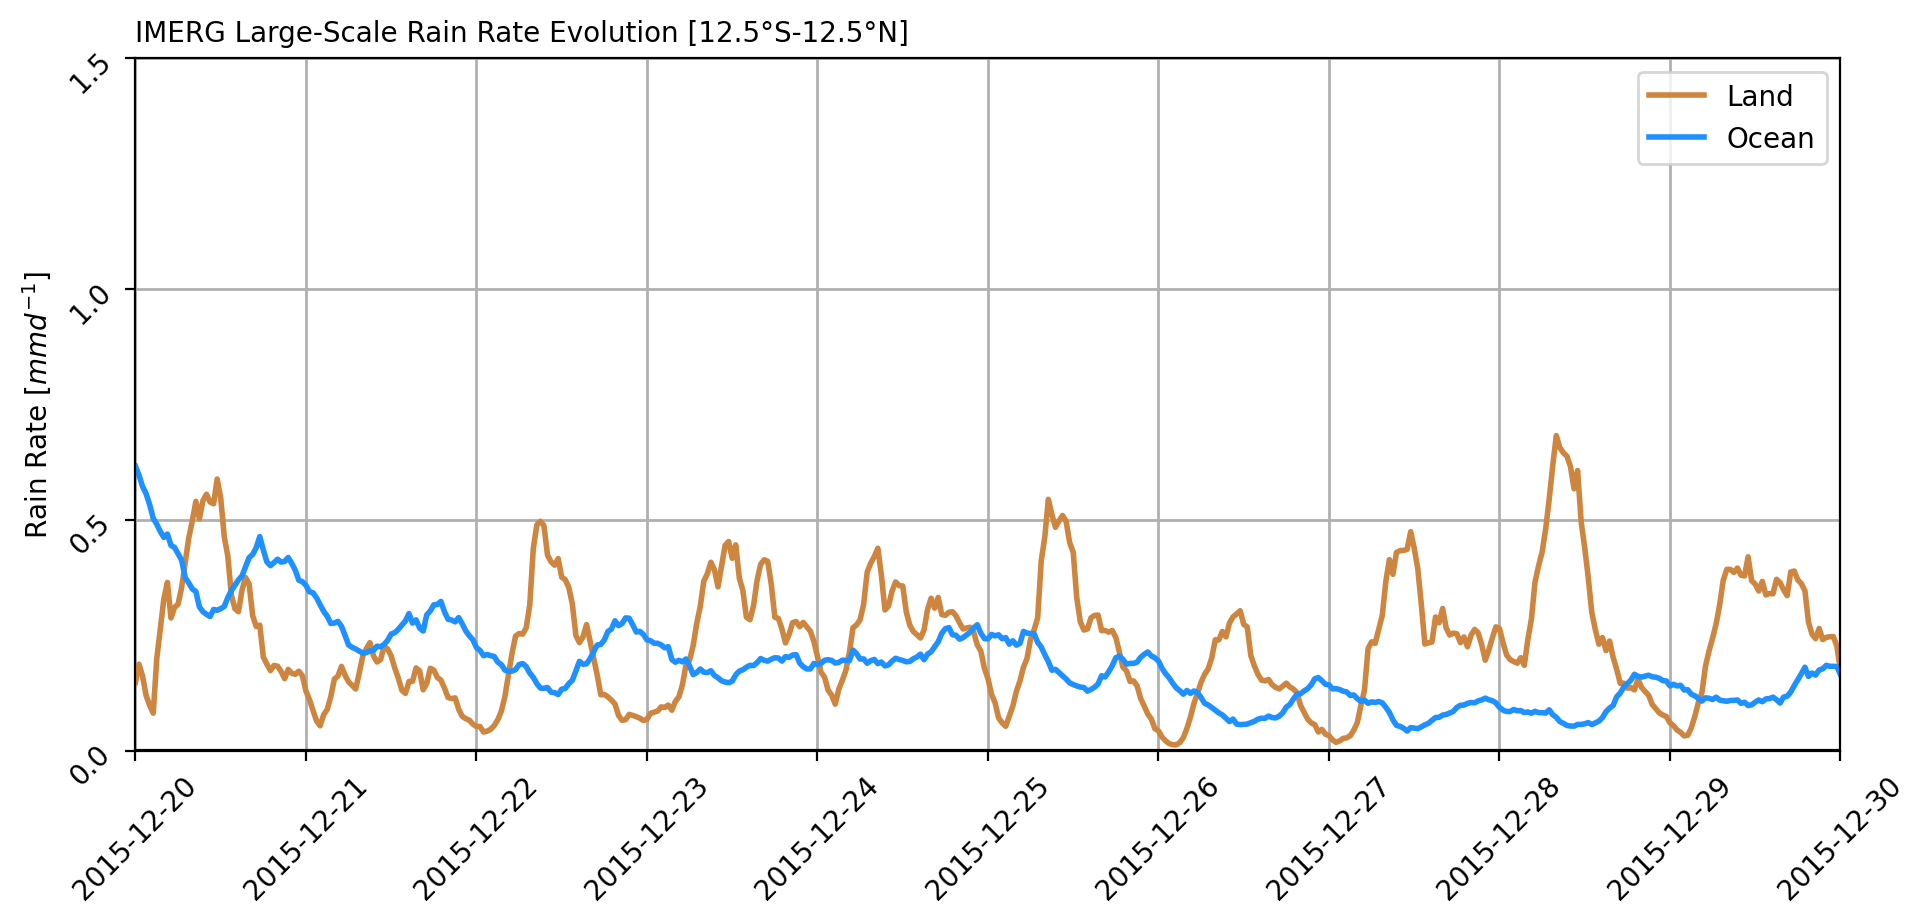

In [185]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

# Land
l1 = xr.where(da_Mask_IMERG<25, da_RR_IMERG, np.nan).mean(dim=['lat','lon']).plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Land'
)

l2 = xr.where(da_Mask_IMERG>=25, da_RR_IMERG, np.nan).mean(dim=['lat','lon']).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Ocean'
)

plt.axhline(y = 0, color = 'k', linestyle = '-')

ax1.grid(linestyle='-', axis='x', linewidth=1)
ax1.grid(linestyle='-', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('IMERG Large-Scale Rain Rate Evolution [12.5°S-12.5°N]', loc='left', fontsize=10)
ax1.set_title('')
ax1.set_yticks(np.arange(0,4,.5))
ax1.tick_params(rotation=45)
ax1.set_xticks(da_RR_IMERG.time[0::48])
ax1.set_xticklabels(np.array(da_RR_IMERG.time[0::48].dt.strftime("%Y-%m-%d")))
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper right')
ax1.set_xlim([da_RR_IMERG.time[0],da_RR_IMERG.time[-1]])
ax1.set_ylim([0,1.5])


Diurnal Composite

In [187]:
## Diurnal Composite of Rain Rate over the MC

	# Land
RR_land = xarray_reduce(da_RR_IMERG.where(da_Mask_IMERG<25), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_land = xr.concat([RR_land,RR_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
RR_ocean = xarray_reduce(da_RR_IMERG.where(da_Mask_IMERG>=25), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_ocean = xr.concat([RR_ocean,RR_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
RR_net = xarray_reduce(da_RR_IMERG, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_net = xr.concat([RR_net,RR_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

## Spatial Diurnal Composite
RR_di = xarray_reduce(da_RR_IMERG, 'LocalTime.hour', func='nanmean', dim='time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','lat','lon')

# Find the max and min values
max_RR_di = RR_di.max(dim='hour', keep_attrs=True)
min_RR_di = RR_di.min(dim='hour', keep_attrs=True)
max_RR_di_land = xr.where(da_Mask_IMERG<25, max_RR_di, np.nan)
max_RR_di_ocean = xr.where(da_Mask_IMERG>=25, max_RR_di, np.nan)

# Find the diurnal range (max-min)
range_RR_di = max_RR_di-min_RR_di
range_RR_di_land = xr.where(da_Mask_IMERG<25, range_RR_di, np.nan)
range_RR_di_ocean = xr.where(da_Mask_IMERG>=25, range_RR_di, np.nan)

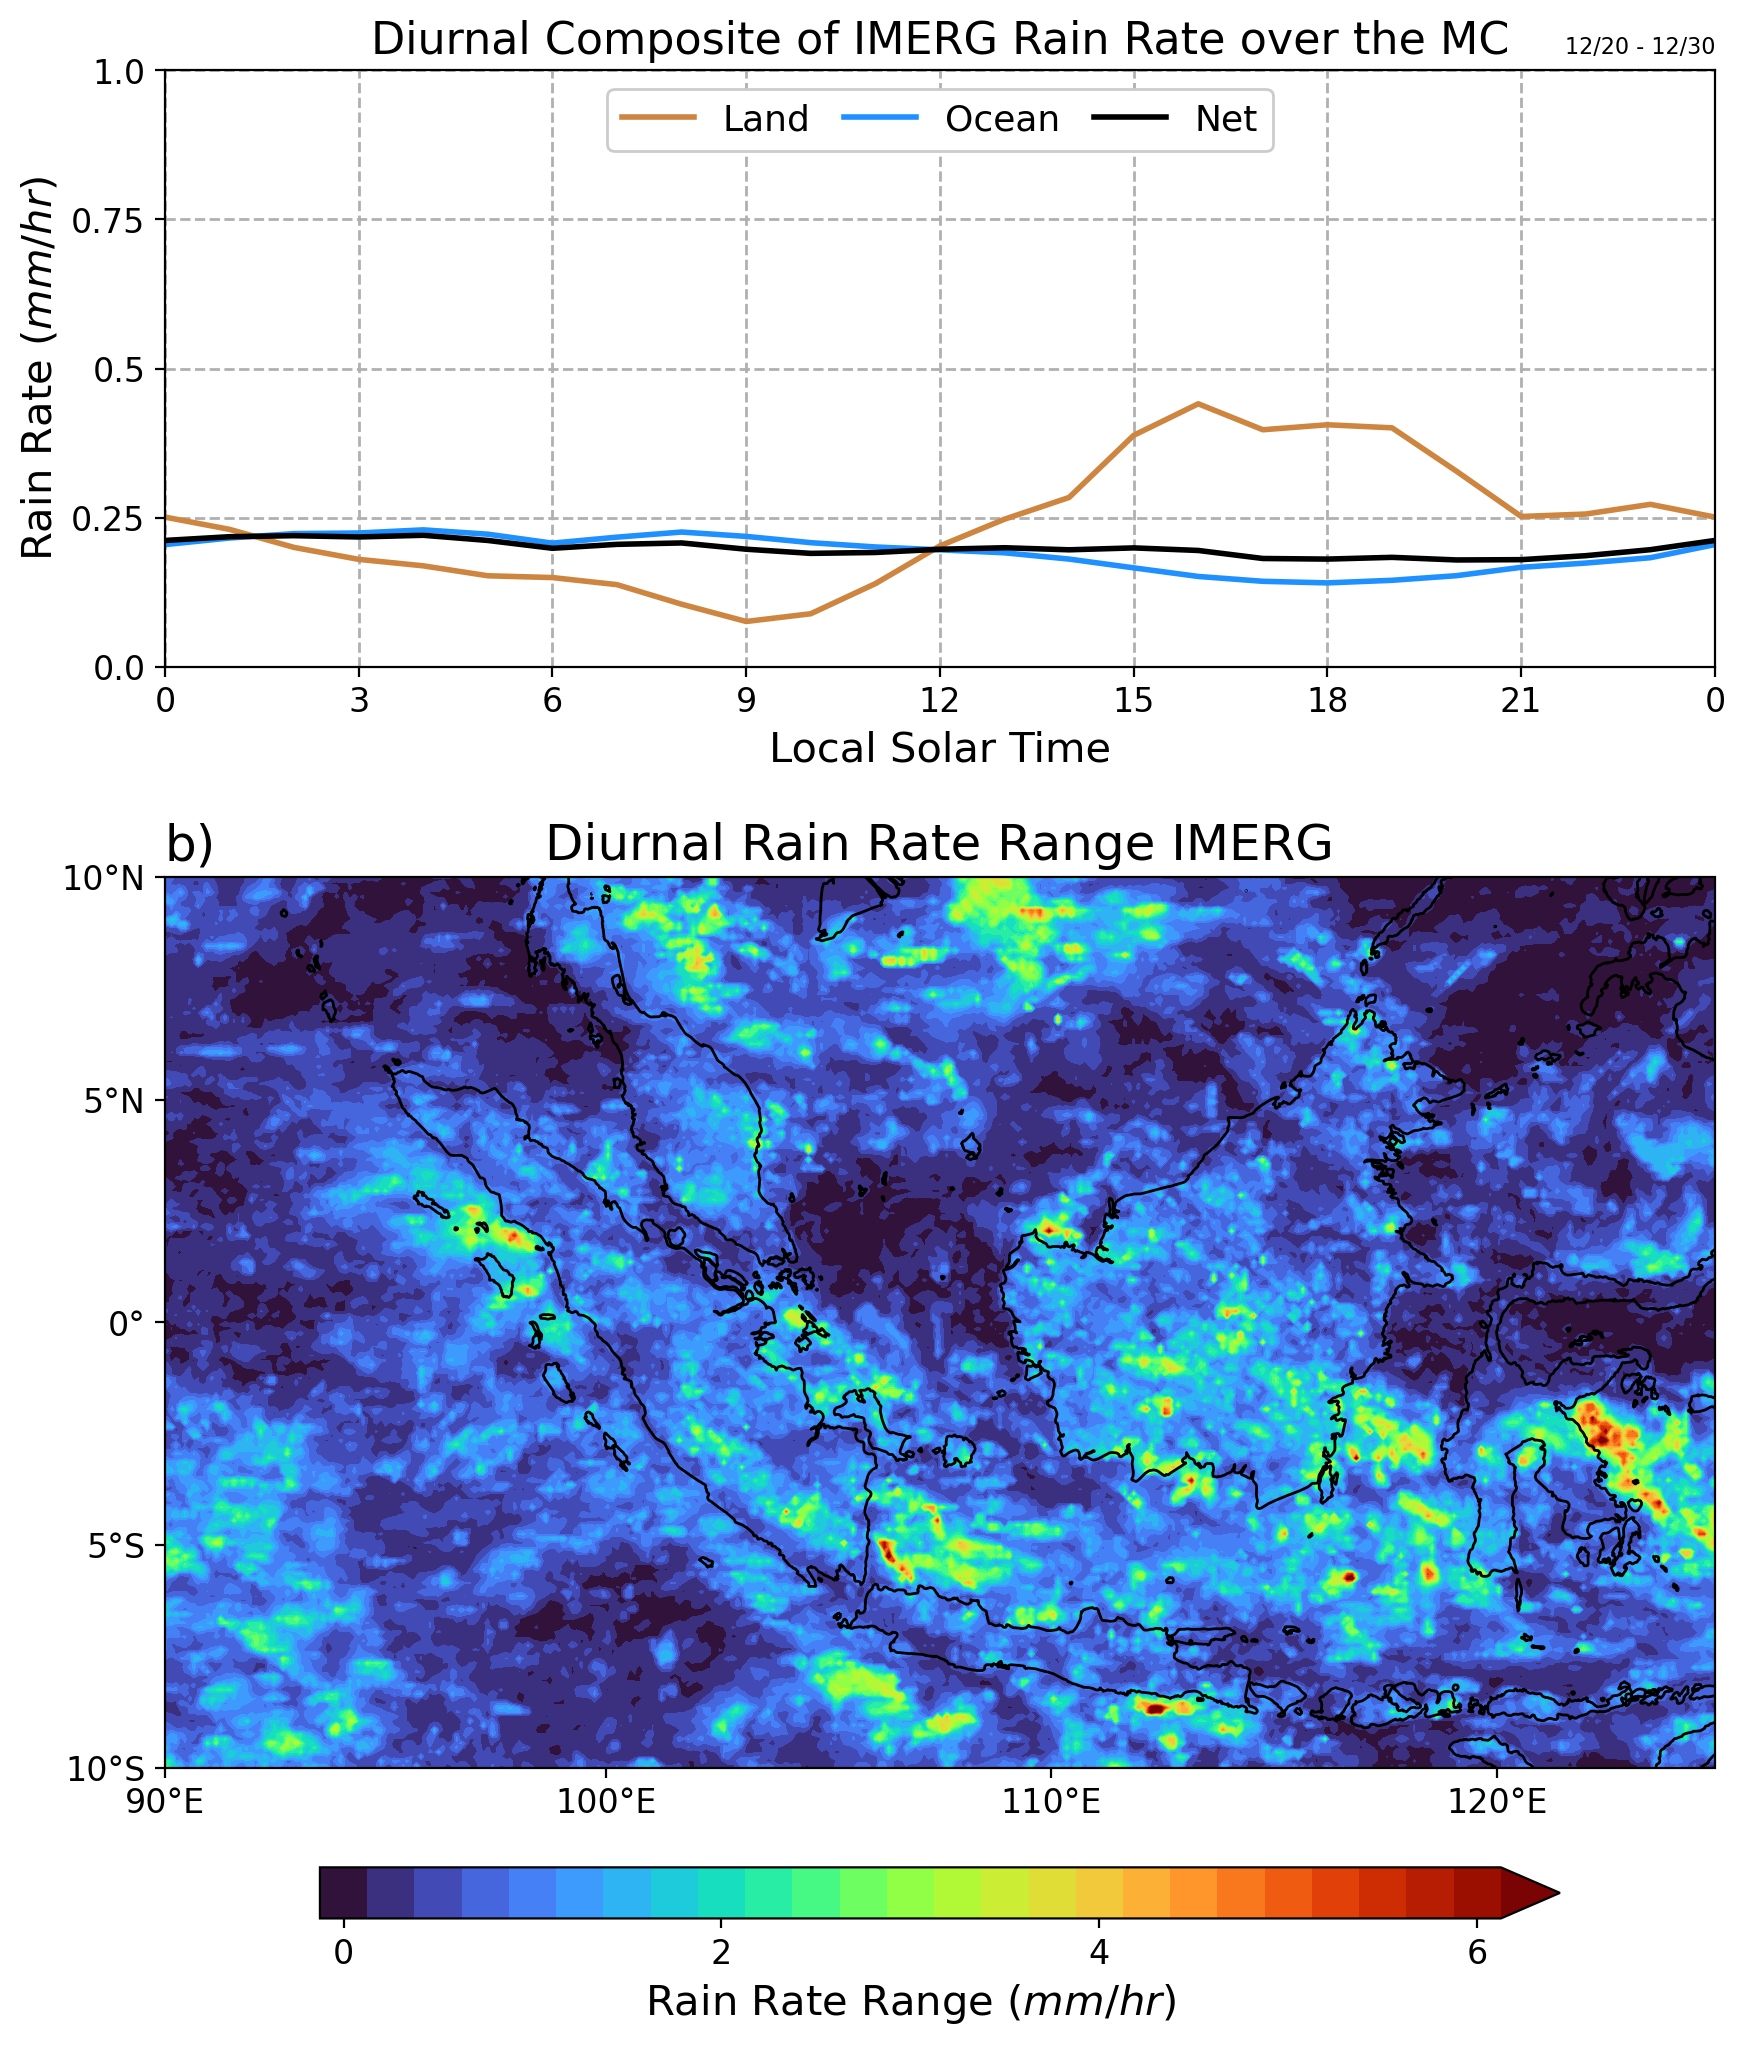

In [188]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0, wspace=0, height_ratios=[.35,.075,.62,.01,.03], width_ratios=[.1,.8,.1])

ax1 = fig.add_subplot(gs[0,:])

fs = 18

# RR-land
l1 = RR_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Land'
)
l2 = RR_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Ocean'
)
l3 = RR_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net'
)

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(0,3,.25))
title = 'Diurnal Composite of IMERG Rain Rate over the MC'
ax1.set_title(title, fontsize=fs-2)
# ax1.set_title('12/15 - 12/25', loc='right', fontsize=fs-10)
# ax1.set_title('12/10 - 12/20', loc='right', fontsize=fs-10)
ax1.set_title('12/20 - 12/30', loc='right', fontsize=fs-10)
# ax1.set_title('12/01 - 12/10', loc='right', fontsize=fs-10)
ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,3,.25), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-5, loc='upper center', framealpha=1, columnspacing=.92)
ax1.set_xlim([0,24])
ax1.set_ylim([0,1])


ax2 = fig.add_subplot(gs[2,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0, 6]
dl = .25
lon_bound_temp = [90,125]
lat_bound_temp = [-10,10]

# No significance shading
cf = range_RR_di.plot.contourf(
    ax=ax2,
    add_colorbar=False,
    cmap='turbo',
    levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='lon',
    y='lat',
    extend='max',
    xlim=[lon_bound_temp[0], lon_bound_temp[1]],
    ylim=[lat_bound_temp[0], lat_bound_temp[1]],
)


# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3,ax=ax2)
# plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.75,ax=ax2)

# Set parameters and labels
x_ticks = [90.1,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax2.set_title('Diurnal Rain Rate Range IMERG', fontsize=fs, loc='center')
ax2.set_title('b)', loc='left', fontsize=fs)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([90.1,124.9])

ax3 = fig.add_subplot(gs[4,1])
# cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,2))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Rain Rate Range ($mm/hr$)', fontsize=fs-3)


Hovmoller

Text(0, 0.5, '')

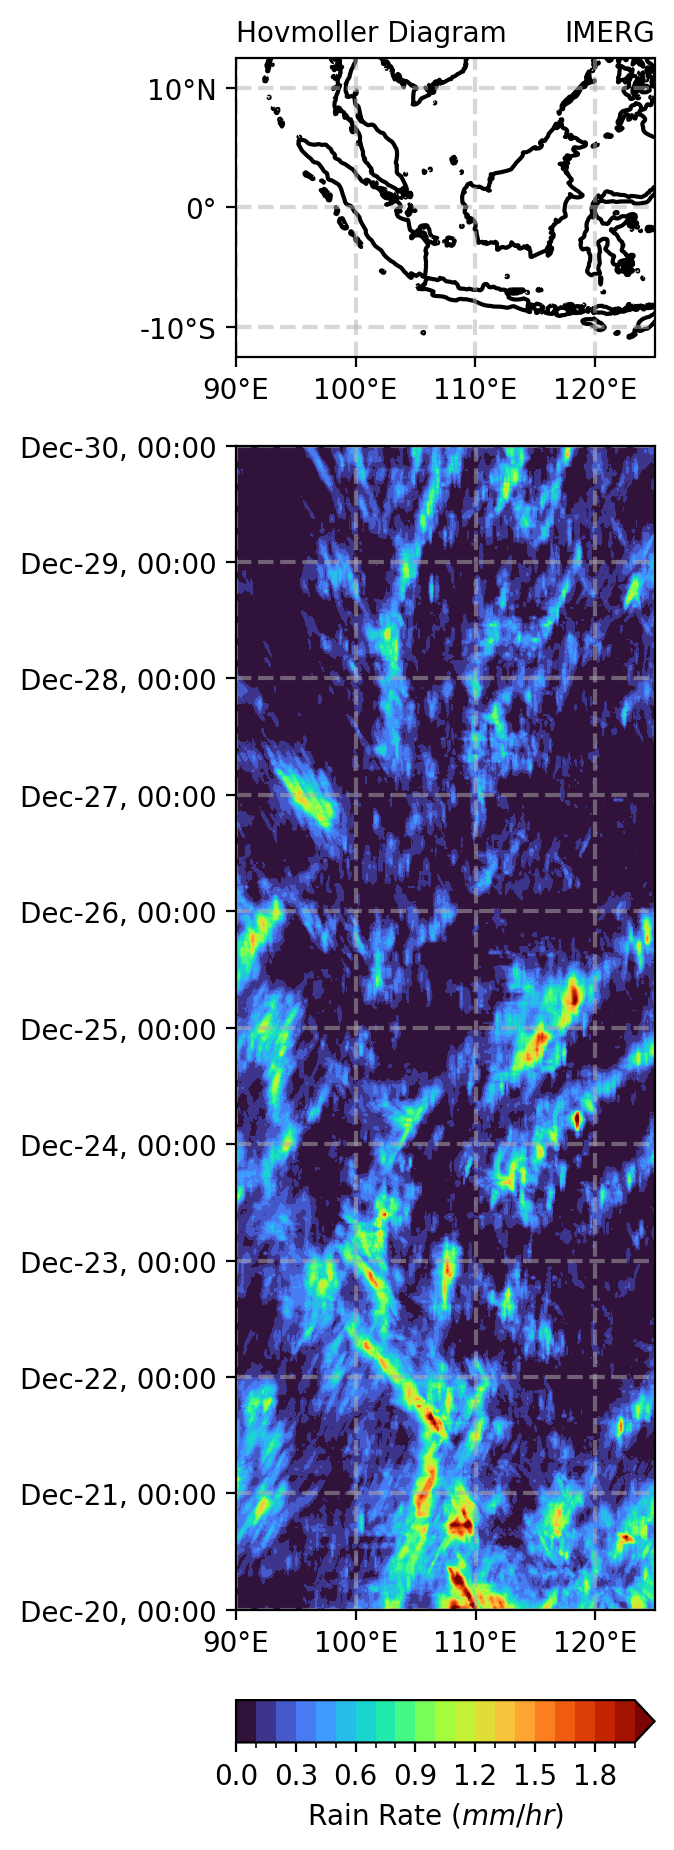

In [183]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(2.7,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=1, hspace=0.075, height_ratios=[0.15,0.015,0.55,0.02,0.02])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, 0, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound_d02[0],lon_bound_d02[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('IMERG', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

ax2 = fig.add_subplot(gs[2, 0]) # ax2.invert_yaxis()

## Preparing data to be plotted
# Read in the data:
x1 = da_RR_IMERG.sel(lat=slice(-10,10)).mean('lat')

# Plot the rain rates
cf2 = x1.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d02[0],lon_bound_d02[1],10),
	cmap='turbo',
	levels=np.arange(0,2.1,.1),
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', linewidth=1.5, alpha=.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 0])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate ($mm/hr$)')

# Set titles/labels
# ax2.set_title('Rain rate', loc='left', fontsize=10)
ax2.set_title('', loc='right', fontsize=10)
ax2.set_xticklabels(x_tick_labels)
# ax2.set_yticks(y.time[0::4])
t = x1.time[::48].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.time[::48])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('')
ax2.set_ylabel('')


#### Cross Sectional Analysis

In [103]:
# Collect the cross sectional data from the now rotated coordinate system
start_coord		= [-1.8,103.8]
end_coord 		= [-5.8,99.8]
width			= 1.5
dx 				= 0.025
# Same analysis but with rain rate
da_cross_temp, all_line_coords = cross_section_multi(da_RR_IMERG, start_coord, end_coord, width, dx)

distance = np.linspace(0,dist(start_coord[0], start_coord[1], end_coord[0], end_coord[1]),da_cross_temp.shape[1])
# d01 coast
distance = distance - distance[18]

da_d01_RR_cross = xr.DataArray(
	data=da_cross_temp,
	dims=('Time','Distance','Spread'),
	coords={'Time':da_RR_IMERG['time'].values,
		 'Distance':distance,
		 'Spread':np.arange(width/2,-width/2,-dx),
		 'Lat': (('Distance','Spread'), all_line_coords[0,:,:]),
		 'Lon': (('Distance','Spread'), all_line_coords[1,:,:])}
	)

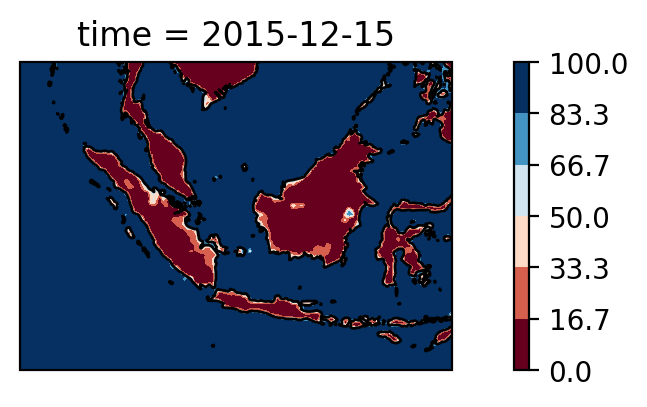

In [36]:
# Testing IMERG MASK
fig = plt.figure(figsize=(8,2))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
# cf1 = da_Mask_IMERG[0,...].where(da_Mask_IMERG[0,...]<50).plot.contourf(
# 	cmap='RdBu',		# _r reverses the colorbar order!
#     vmin=0,vmax=100
# )
cf1 = da_Mask_IMERG[0,...].plot.contourf(
	cmap='RdBu',		# _r reverses the colorbar order!
    vmin=0,vmax=100
)
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function


[Text(0, -6, '6°S'), Text(0, -4, '4°S'), Text(0, -2, '2°S')]

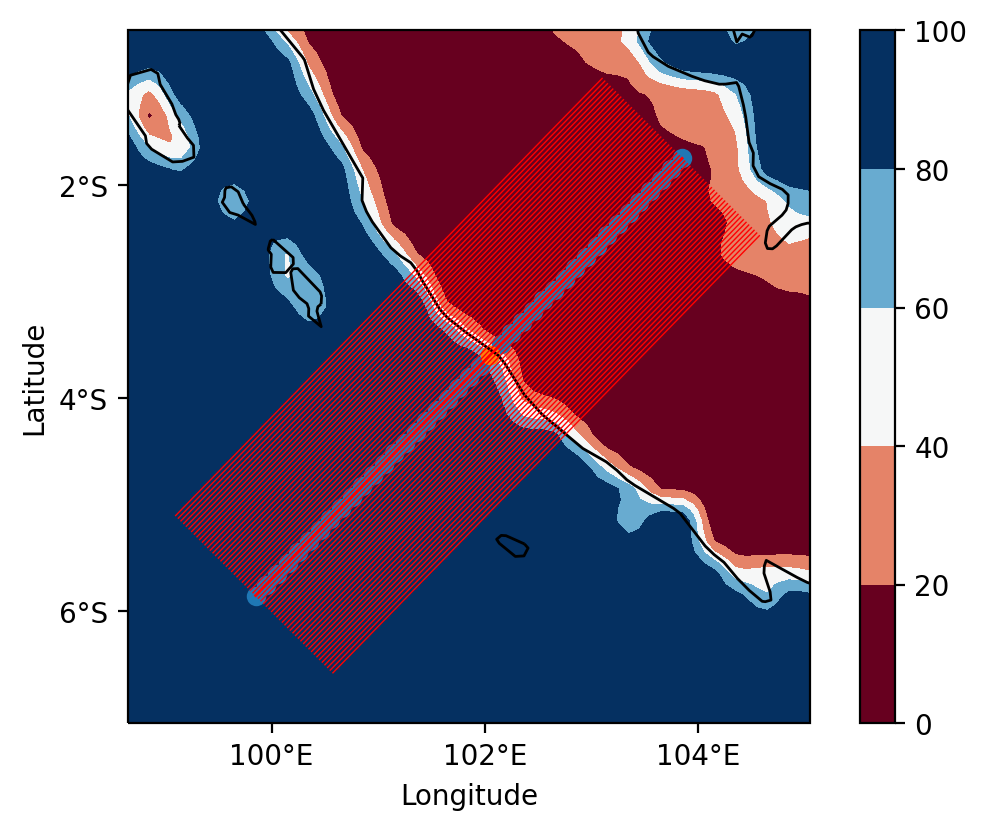

In [104]:
fig = plt.figure(figsize=(6.5,4.5))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# d02_coords = dict(
#     south_north=('south_north',ds_d02.XLAT[0,:,0].values),
#     west_east=('west_east',ds_d02.XLONG[0,0,:].values)
#     )
# # # Terrain Height    [m]
# da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
# x = da_d02_TOPO.assign_coords(d02_coords)
width=0.75
lat = [all_line_coords[0,...].max()+0.5,all_line_coords[0,...].min()-0.5]
lon = [all_line_coords[1,...].min()-0.5,all_line_coords[1,...].max()+0.5]
# lat = [-2,-6]
# lon = [100,104]
# lat = np.add([-2,-6],0.2)
# lon = np.subtract([100,104],0.2)
# lat = np.add([0,-8],0.2)
# lon = np.subtract([98,106],0.2)
# Yokoi et al. 2017-2019 domain:
x = da_Mask_IMERG[0,...]
x = x.sel(
	lat=slice(lat[1],lat[0]),
	lon=slice(lon[0],lon[1]))
# x = x.sel(
# 	south_north=slice(lat[1]-(width*1.5),lat[0]+(width*1.5)),
# 	west_east=slice(lon[0]-(width*1.5),lon[1]+(width*1.5)))
x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']


# # Summatra domain:
# x = x.sel(
# 	south_north=slice(-7.5,7.5),
# 	west_east=slice(95,105))
# x_ticks = np.array([95,100,105])
# x_tick_labels = [u'95\N{DEGREE SIGN}E',
#                  u'100\N{DEGREE SIGN}E', u'105\N{DEGREE SIGN}E']
# y_ticks = np.array([-7.5,0,7.5])
# y_tick_labels = [u'7.5\N{DEGREE SIGN}S',
#                  u'0\N{DEGREE SIGN}N', u'7.5\N{DEGREE SIGN}N']
# lat = [5.5,-6.5]
# lon = [95.05,104.95]


ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function
cf1 = x.plot.contourf(
	cmap='RdBu',
	# cmap='gray',
	# levels=np.arange()
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.65,50))
)
dx = 0.025
# plt.plot(lon,lat,'y')
# plt.plot(lon,lat[::-1],'r',linewidth=1)
all_line_coords
for i in range(int(all_line_coords.shape[2])):
	# plt.plot(np.subtract(lon,i*dx),np.add(lat[::-1],i*dx),'r',linewidth=0.5)
	# plt.plot(np.add(lon,i*dx),np.subtract(lat[::-1],i*dx),'r',linewidth=0.5)
	plt.plot(all_line_coords[1,:,i],all_line_coords[0,:,i],'r',linewidth=0.5)
	# plt.plot(np.add(lon,i*dx),np.subtract(lat[::-1],i*dx),'r',linewidth=0.5)
plt.plot(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)],'r',linewidth=1)
plt.scatter(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)])
# Plot where you think the coastline will be
plt.scatter(all_line_coords[1,int(all_line_coords.shape[1]/2)-2,int(all_line_coords.shape[2]/2)],all_line_coords[0,int(all_line_coords.shape[1]/2)-2,int(all_line_coords.shape[2]/2)])

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)


In [102]:
int(all_line_coords.shape[1]/2)-2

18

In [97]:
x = da_Mask_IMERG[0,...].interp(
	lat=da_d01_RR_cross.Lat[:,30].values,
	lon=da_d01_RR_cross.Lon[:,30].values
)

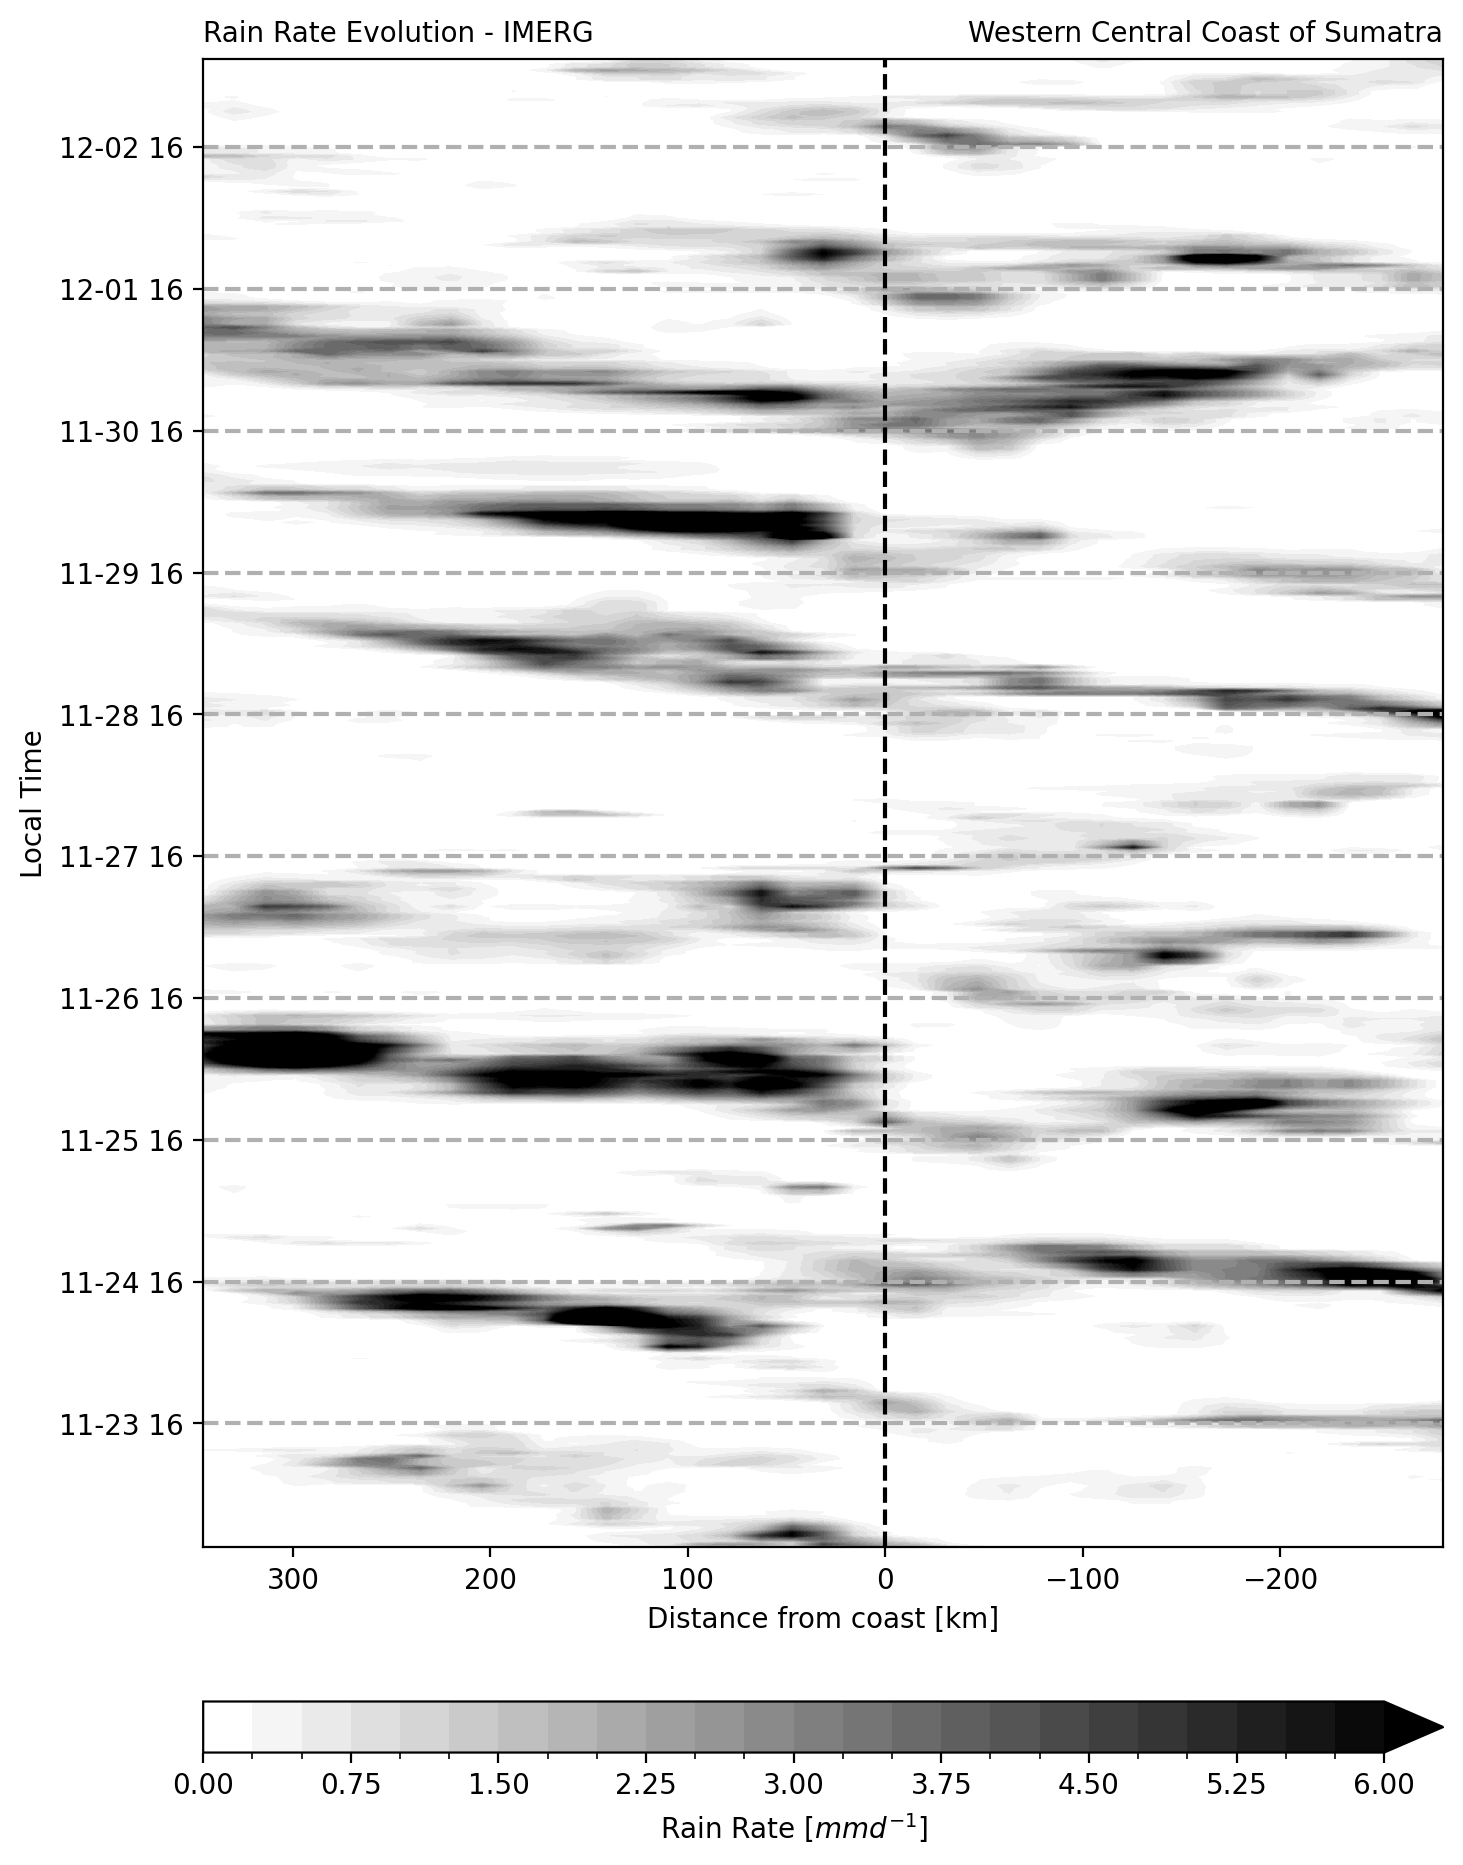

In [105]:
fig = plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.2, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Average over each cross-section
x1 = da_d01_RR_cross
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.mean('Spread')

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)


# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x1.Time[42::48].values)
ax1.set_yticklabels(x1.Time[42::48].dt.strftime("%m-%d %H").values)
# Set titles/labels
ax1.set_title('Rain Rate Evolution - IMERG', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
# Create grids
# ax1.grid(linestyle='--', axis='x', linewidth=1.5)
ax1.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')


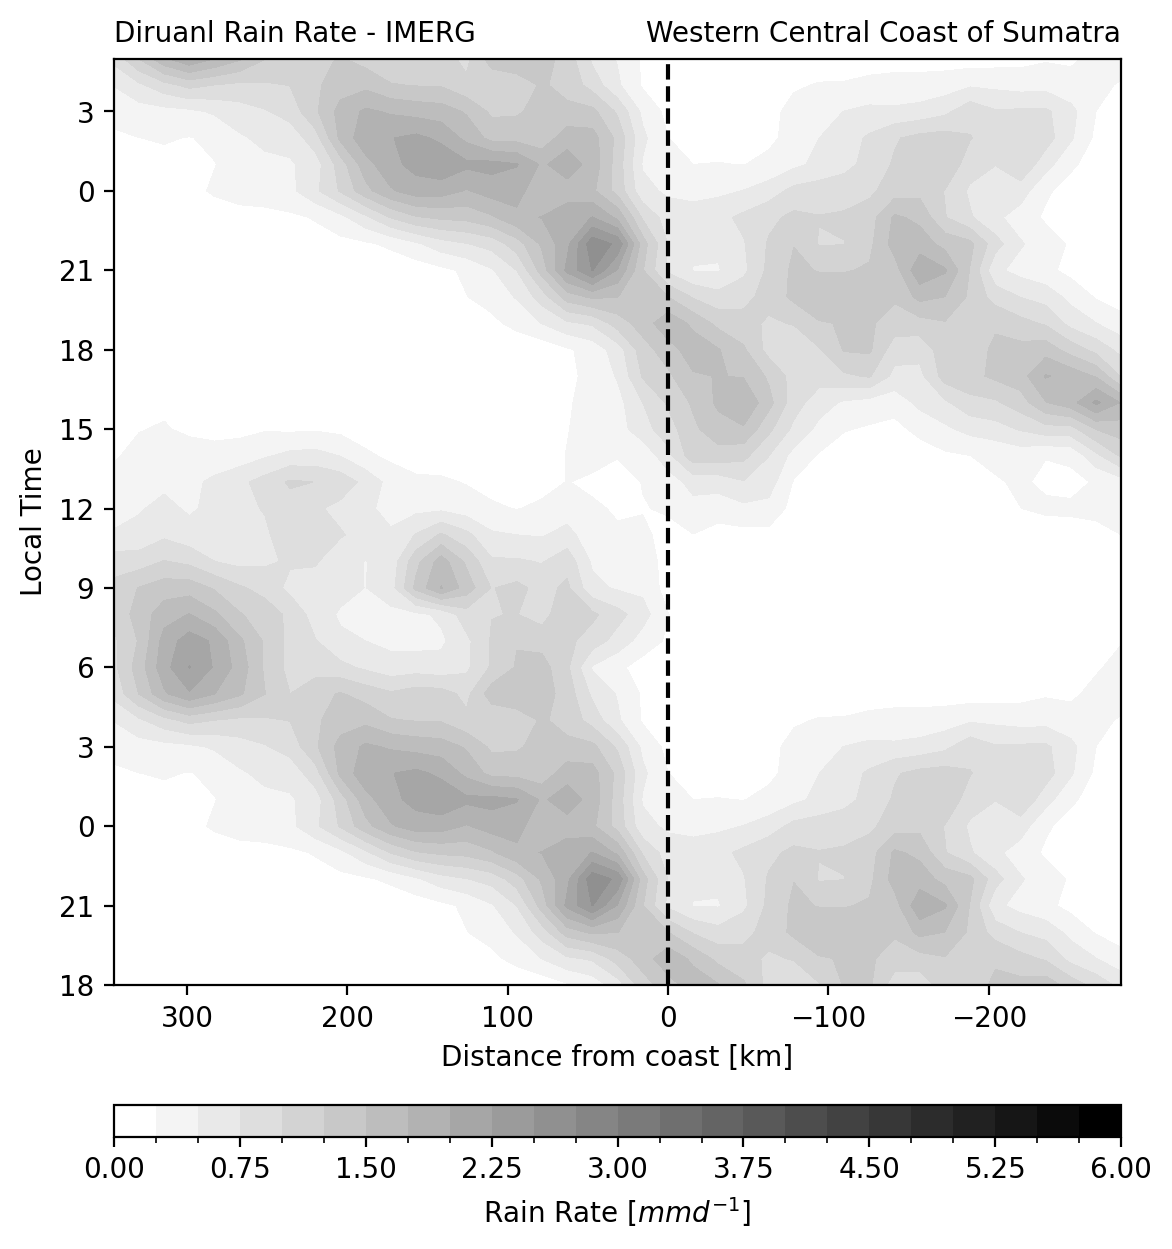

In [106]:
fig = plt.figure(figsize=(6.5,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Composite diurnally, and then average over each cross-section
x1 = da_d01_RR_cross
# Switch to local time
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.groupby('Time.hour').mean().mean('Spread')
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

# Plot the cross-sectional data
cf1 = x2.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x2.hour[0::3].values)
ax1.set_yticklabels(yticks[0::3])
# Set titles/labels
ax1.set_title('Diruanl Rain Rate - IMERG', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

